In [59]:
###  for ncluster plots in paper for double cluster analysis in the combination paper


import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import  make_datacard_2sig, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [95]:
fpath =OrderedDict()
tree = OrderedDict()

data_year = 'full'

ctau = '1000'
masses = ['7', '15','40','55']
ntupler_version = 'V1p17/'
analyzer_version = "/v1/v167/"
decay = 'dddd'
ct = 1000

prod = ['ggH', 'VBFH','ZH', 'WH', 'ttH','ggZH']

ntupler_version = 'V1p17/'
mc_path = {}
analyzer_version = 'v1/v163/'
mc_central_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
analyzer_version = 'v2/v163/'
mc_private_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'


for p in prod:
    for m in masses:
        key = 'MC_'+p + '_'+m+'_'+str(ct)
        if p == 'ggH':
            fpath[key] = mc_central_path+p+'_HToSSTodddd_MH-125_MS-'+m+'_ctau-'+str(ct)+'_137000pb_weighted.root'
        else:
            if 'ggH' in p or 'ttH' in p: fpath[key] = mc_private_path+p+'_HToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
            elif p == 'VBFH' or p=='ZH' or p == 'WH': fpath[key] = mc_private_path+p+'ToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
            elif 'ggZH' in p:fpath[key] = mc_private_path+'ZHToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
        if not os.path.exists(fpath[key]):print('FILE NOT FOUND',key, fpath[key])

                


analyzer_version = "/v5/v163/"
data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version+'/normalized/'
fpath['data'] = data_path +'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print(k, "NEvents",NEvents[k])


root_dir = uproot.open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root') 
h_reweight = root_dir['higgsPthiggsEta']

MC_ggH_7_1000 NEvents 106227390.0
MC_ggH_15_1000 NEvents 102585040.0
MC_ggH_40_1000 NEvents 106752310.0
MC_ggH_55_1000 NEvents 104310510.0
MC_VBFH_7_1000 NEvents 517427.94
MC_VBFH_15_1000 NEvents 579324.2
MC_VBFH_40_1000 NEvents 771304.4
MC_VBFH_55_1000 NEvents 577754.06
MC_ZH_7_1000 NEvents 328973.38
MC_ZH_15_1000 NEvents 333179.34
MC_ZH_40_1000 NEvents 150467.9
MC_ZH_55_1000 NEvents 157271.38
MC_WH_7_1000 NEvents 278592.3
MC_WH_15_1000 NEvents 278505.12
MC_WH_40_1000 NEvents 280029.44
MC_WH_55_1000 NEvents 279076.75
MC_ttH_7_1000 NEvents 104786.51
MC_ttH_15_1000 NEvents 104781.12
MC_ttH_40_1000 NEvents 101989.2
MC_ttH_55_1000 NEvents 102549.61
MC_ggZH_7_1000 NEvents 328973.38
MC_ggZH_15_1000 NEvents 333179.34
MC_ggZH_40_1000 NEvents 150467.9
MC_ggZH_55_1000 NEvents 157271.38
data NEvents 22763250.0


# nCsc with different hit vetoing

In [97]:

jetPt_cut = 50

weight = {}
nhits1 = {}
nhits2 = {}
sel_ev = {}
cond = {}
ggZH_weight = {}
higgsEta = {}
higgsPt = {}

nCosmic = {}
deltaEta = {}
deltaRCluster = {}
jetPt = {}

cluster_index = ''
addNoiseFlag = 1
# 0: 2 CSC; 1: 2DT; 2: csc+dt

for k in list(tree.keys()):
    ########### SELECTION: CLUSTERS ############
    if 'data' in k: T = tree['data']
    else: T = tree[k]

    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

    if 'data' in k: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))
    else: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))

    sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId'))))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))


    cut = 5
    station = (T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))

    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) #remove if both clusters are 4 stations
    if addNoiseFlag and not 'data' in k: 
        sel_dtcluster = np.logical_and(sel_dtcluster, (T.array('dtRechitClusterSize')+T.array('dtRechitClusterNoiseHit')) >= 50)
    else: sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitClusterSize') >= 50)




    ###################### cosmic muon veto #############
    sel_cosmic = np.logical_and(T.array('dtRechitClusterNOppositeSegStation1')>0, T.array('dtRechitClusterNOppositeSegStation2')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation3')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation4')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation1')+T.array('dtRechitClusterNOppositeSegStation2')+\
                               T.array('dtRechitClusterNOppositeSegStation3')+T.array('dtRechitClusterNOppositeSegStation4')>=6)
    nstation = (T.array('dtRechitClusterNSegmentStation1')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>1).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>1).astype(int)

    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(nstation>=3, sel_cosmic)))

########### SELECTION: JETS ############

    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)



########### SELECTION: NOISE IN DT ############

    spike = np.logical_and( T.array('nDTRechitsSector')[:,0,0,7]>50,  T.array('nDTRechitsSector')[:,0,0,7]+T.array('nDTRechitsSector')[:,0,0,8]+T.array('nDTRechitsSector')[:,0,0,9]>120)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,8]>25)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,9]>10)



########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METNoMuTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') >= 200)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    sel_ev[k] = np.logical_and(sel_ev[k] , np.logical_not(spike))

########### BRANCHES ############



    for category in [0,1,2]:
        
        if category == 0:
            sel_ev_temp  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 2)
            sel_ev_temp  = np.logical_and(sel_ev_temp,sel_dtcluster.sum()== 0)
            cond[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev_temp][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev_temp][:,0],\
                            T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev_temp][:,1], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev_temp][:,1])<2


            nhits1[k+str(category)] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev_temp][cond[k]][:,0]
            nhits2[k+str(category)] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev_temp][cond[k]][:,1]
        elif category == 1:
            sel_ev_temp  = np.logical_and(sel_ev[k],sel_dtcluster.sum()== 2)
            sel_ev_temp  = np.logical_and(sel_ev_temp,sel_csccluster.sum()== 0)
            cond[k] = np.abs(T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev_temp][:,0]-\
                                                        T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev_temp][:,1])>=0
            if addNoiseFlag and not 'data' in k:
                nhits1[k+str(category)] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev_temp][:,0]
                nhits2[k+str(category)] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev_temp][:,1]
            else:
                nhits1[k+str(category)] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev_temp][:,0]
                nhits2[k+str(category)] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev_temp][:,1]
        elif category == 2:
            sel_ev_temp  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
            sel_ev_temp  = np.logical_and(sel_ev_temp,sel_dtcluster.sum() == 1)

    #         cond[k] =  np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev_temp][:,0]-\
    #                                                     T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev_temp][:,0])<2.0

            cond[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev_temp][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev_temp][:,0],\
                            T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev_temp][:,0], T.array('dtRechitCluster' + cluster_index + 'Phi')[sel_dtcluster][sel_ev_temp][:,0])<2.5
            if addNoiseFlag and not 'data' in k:
                nhits1[k+str(category)] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev_temp][cond[k]][:,0]
            else:
                nhits1[k+str(category)] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev_temp][cond[k]][:,0]
            nhits2[k+str(category)] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev_temp][cond[k]][:,0]



        else:
            assert(False)


        higgsPt = T.array('gHiggsPt')[sel_ev_temp][cond[k]]
        higgsEta = T.array('gHiggsEta')[sel_ev_temp][cond[k]]
        ggZH_weight=h_reweight.values[np.argmax(h_reweight.edges[0]>higgsPt[:,None],axis=1)-1, np.argmax(h_reweight.edges[1]>np.abs(higgsEta)[:,None],axis=1)-1]
        
        if 'data' in k:
            weight[k+str(category)] = np.ones(np.count_nonzero([cond[k]]))
        else:
            if 'ggH' in k: weight[k+str(category)] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev_temp][cond[k]]
            else:weight[k+str(category)] = (T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev_temp][cond[k]]
            if 'ggZH' in k: weight[k+str(category)] *= ggZH_weight


In [102]:
nhits1.keys()

dict_keys(['MC_ggH_7_10000', 'MC_ggH_7_10001', 'MC_ggH_7_10002', 'MC_ggH_15_10000', 'MC_ggH_15_10001', 'MC_ggH_15_10002', 'MC_ggH_40_10000', 'MC_ggH_40_10001', 'MC_ggH_40_10002', 'MC_ggH_55_10000', 'MC_ggH_55_10001', 'MC_ggH_55_10002', 'MC_VBFH_7_10000', 'MC_VBFH_7_10001', 'MC_VBFH_7_10002', 'MC_VBFH_15_10000', 'MC_VBFH_15_10001', 'MC_VBFH_15_10002', 'MC_VBFH_40_10000', 'MC_VBFH_40_10001', 'MC_VBFH_40_10002', 'MC_VBFH_55_10000', 'MC_VBFH_55_10001', 'MC_VBFH_55_10002', 'MC_ZH_7_10000', 'MC_ZH_7_10001', 'MC_ZH_7_10002', 'MC_ZH_15_10000', 'MC_ZH_15_10001', 'MC_ZH_15_10002', 'MC_ZH_40_10000', 'MC_ZH_40_10001', 'MC_ZH_40_10002', 'MC_ZH_55_10000', 'MC_ZH_55_10001', 'MC_ZH_55_10002', 'MC_WH_7_10000', 'MC_WH_7_10001', 'MC_WH_7_10002', 'MC_WH_15_10000', 'MC_WH_15_10001', 'MC_WH_15_10002', 'MC_WH_40_10000', 'MC_WH_40_10001', 'MC_WH_40_10002', 'MC_WH_55_10000', 'MC_WH_55_10001', 'MC_WH_55_10002', 'MC_ttH_7_10000', 'MC_ttH_7_10001', 'MC_ttH_7_10002', 'MC_ttH_15_10000', 'MC_ttH_15_10001', 'MC_ttH_1

# unblinded result plots (2bin)

7.0
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/result_double//v5/v163//category0_ncluster_dddd_paper.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/result_double//v5/v163//category0_ncluster_dddd_paper.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_je

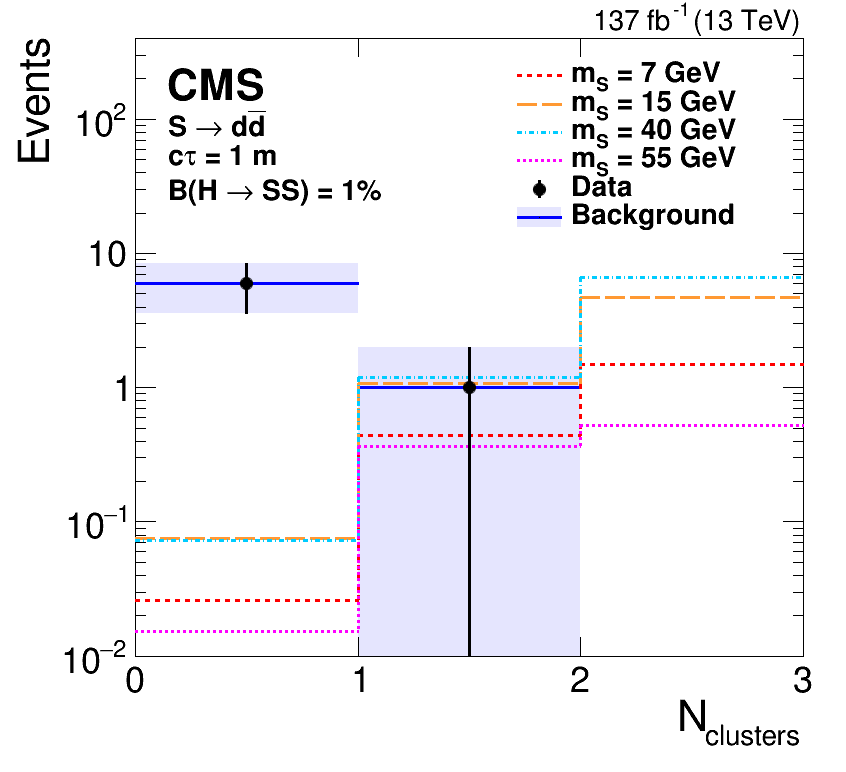

In [113]:
import os
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle
unblind = 0
category = 0




xaxis_title = 'N_{clusters}'
bins = [3,0,3]

if index == 0: leg = rt.TLegend(0.64,0.70,0.92,0.92)
else: leg = rt.TLegend(0.60,0.70,0.90,0.92)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}

if category == 0:
    threshold1 = 100
    threshold2 = 100
elif category == 1:
    threshold1 = 80
    threshold2 = 80
else: 
    threshold1 = 80
    threshold2 = 100
        
# plot signal
for i, m in enumerate(masses):
    array = []
    weight_temp = []
    for p in prod:
        k = 'MC_'+p + '_'+m+'_'+str(ct)+str(category)
    

        bin0= np.logical_and(nhits1[k]< threshold1, nhits2[k]<threshold2)
        bin2 = np.logical_and(nhits1[k]>= threshold1, nhits2[k]>=threshold2)
        bin1 = np.logical_not(np.logical_or(bin0, bin2))
        count = np.ones(nhits1[k].shape)
        count[bin0] = 0
        count[bin1] = 1
        count[bin2] = 2
            
        array+= list(count)
        weight_temp += list(weight[k]*0.01)
            
    h[k] = create_TH1D(array,  axis_title=[xaxis_title, 'Events'], binning = bins,weights = weight_temp)

    if i == 1:h[k].SetLineColor(801)
#     elif i == 2:h[k].SetLineColor(819)
    elif i == 2:h[k].SetLineColor(870)
    else:h[k].SetLineColor(std_color_list[i+1])
    leg.AddEntry(h[k],"m_{S} = "+m+" GeV",'L')

#plot data
k = 'data'+str(category)
bin0= np.logical_and(nhits1[k]< threshold1, nhits2[k]<threshold2)
bin2 = np.logical_and(nhits1[k]>= threshold1, nhits2[k]>=threshold2)
bin1 = np.logical_not(np.logical_or(bin0, bin2))
count = np.ones(nhits1[k].shape)
count[bin0] = 0
count[bin1] = 1
if 'data' in k and not unblind: count[bin2] = -999 #change this to 2 when unblind
h[k] = create_TH1D(count,  axis_title=[xaxis_title, 'Events'], binning = bins)
leg.AddEntry(h[k], 'Data','EP')

# h['data0'].Draw('esamex0')
# plot bkg only fit
bkg = [0,1,2]
if category == 0: w = [6,1,0] #bin C/D
elif category == 1: w = [3,1,0] #bin C/D
elif category == 2: w = [14,3,0] #bin C/D

h['bkg'] = create_TH1D(bkg,  axis_title=[xaxis_title, 'Events'], binning = bins, weights = w)
print(h['bkg'].Integral())

h['bkg'].SetBinError(1, h['bkg'].GetBinContent(1)**0.5) #bin C error
h['bkg'].SetBinError(2,1) #SR
h['bkg'].SetBinError(3,1) #SR

h['bkg'].SetLineWidth(3)
h['bkg'].SetLineColor(4)

h['bkg_err'] = h['bkg'].Clone()

leg.AddEntry(h['bkg_err'], 'Background')

h['bkg_err'].SetLineWidth(3)
h['bkg_err'].SetLineColor(4)
h['bkg_err'].SetFillColorAlpha(4,0.1)

h['bkg_err'].Draw('l E2 same')
h['bkg'].SetBinError(1, 0.001)
h['bkg'].SetBinError(2,0.001) #SR
h['bkg'].Draw('L same')


for k in h.keys():
    h[k].SetLineWidth(3)
#     h[k].GetYaxis().SetRangeUser(0.5,400)
    h[k].GetYaxis().SetRangeUser(0.01,400)
    h[k].GetXaxis().SetNdivisions(3,0,0,False)
    if 'bkg' in k:continue
    if 'data' in k:
        h[k].SetLineColor(1)
        h[k].SetMarkerStyle(20)
        h[k].SetMarkerSize(1.5)
        
        h[k].Draw('esamex0')
    else:
        
        
        h[k].SetLineStyle(9)
        if  '7' in k:h[k].SetLineStyle(7)
        elif '15' in k:h[k].SetLineStyle(9)
        elif  '40' in k:h[k].SetLineStyle(5)
        elif  '55' in k:h[k].SetLineStyle(2)
        h[k].Draw(' hist same')
# for k,v in h.items():print(k, v.Integral())
# h['data_unblind'].Draw('esamex0')


latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)

latex = rt.TLatex()
latex.SetTextSize(0.04)
# if index == 1:
x = 0.15
# if decay == 'dddd': latex.DrawLatex(x,30,  "S #rightarrow d#bar{d}")
# elif decay == 'bbbb': latex.DrawLatex(x,30, "S #rightarrow b#bar{b}")
# elif decay == '4Tau': latex.DrawLatex(x,30, "S #rightarrow #tau^{+}#tau^{-}")
# latex.DrawLatex(x,20, "c#tau = 1 m")
# latex.DrawLatex(x,12, "B(H #rightarrow SS) = 1%")


if decay == 'dddd': latex.DrawLatex(x,75,  "S #rightarrow d#bar{d}")
elif decay == 'bbbb': latex.DrawLatex(x,90, "S #rightarrow b#bar{b}")
elif decay == '4Tau': latex.DrawLatex(x,90, "S #rightarrow #tau^{+}#tau^{-}")
latex.DrawLatex(x,45, "c#tau = 1 m")
latex.DrawLatex(x,25, "B(H #rightarrow SS) = 1%")


# else:
#     x = 180
#     latex.DrawLatex(75,110, '#Delta#it{#phi} < 0.75 required')
#     latex.DrawLatex(x,27, "B(H #rightarrow SS) = 1%")
#     latex.DrawLatex(x,40, "c#tau = 1 m")

#     if decay == 'dddd': latex.DrawLatex(x,55,  "S #rightarrow d#bar{d}")
#     elif decay == 'bbbb': latex.DrawLatex(x,55, "S #rightarrow b#bar{b}")
#     elif decay == '4Tau': latex.DrawLatex(x,55, "S #rightarrow #tau^{+}#tau^{-}")

        
# l.SetLineWidth(2)
# l.Draw()    


c.SetRightMargin(0.05)
c.SetBottomMargin(0.15)



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 0
CMS_lumi.extraText   = "Preliminary"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.12
CMS_lumi.relPosY = 0.05
CMS_lumi.cmsTextSize      = 1.2


CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
outDir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/result_double/'+analyzer_version
if unblind:outDir += '/unblind/'
if not os.path.isdir(outDir):os.makedirs(outDir)

if CMS_lumi.writeExtraText:
    c.SaveAs(outDir+'/category'+str(category)+'_ncluster_'+decay+'_pas_paper.png')
    c.SaveAs(outDir+'/category'+str(category)+'_ncluster_'+decay+'_pas_paper.C')
    c.SaveAs(outDir+'/category'+str(category)+'_ncluster_'+decay+'_pas_paper.pdf')
else:
    c.SaveAs(outDir+'/category'+str(category)+'_ncluster_'+decay+'_paper.png')
    c.SaveAs(outDir+'/category'+str(category)+'_ncluster_'+decay+'_paper.C')
    c.SaveAs(outDir+'/category'+str(category)+'_ncluster_'+decay+'_paper.pdf')